# Clasificación de imágenes utilizando CNN

## CIFAR10 Dataset
El dataset CIFAR10 consiste de 60 mil imágenes de 32x32px en RGB, la cual contiene 10 clases.

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

Descarga del dataset en formato *.png

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
# Extracción
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Contiene 2 carpetas, 'train' y 'test'.
'Train' contiene 50 mil imágenes, y 'Test' 10 mil imágenes.
Cada una contiene 10 carpetas, una por cada clase.

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['ship', 'frog', 'deer', 'horse', 'truck', 'automobile', 'airplane', 'cat', 'bird', 'dog']


Para cargar las imágenes como tensores de Pytorch se utiliza 'ImageFolder' de la librería torchvision.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

Se transforman las imágenes para cargarlas, no sólo se convierten en tensor, sino también se las normailza. En el caso del set de imágenes para train, también se utiliza la función random crop y randomHorizonal Flip, que recortan las imágenes  y las voltean aleatoriamente, para modificar el dataset original.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
#Se carga el set de entrenamiento en memoría, aplicando las transformación antes descripta.
dataset = ImageFolder(data_dir+'/train', transform=transform_train)

Cada elemento del dataset, contiene el tensor de 32x32 por 3 canales (RGB) y su etiqueta.

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [ 2.3784,  2.2039,  1.7775,  ...,  0.6725,  1.1959, -2.4291],
         [ 2.3396,  2.3396,  2.3978,  ...,  0.6725,  1.2541, -2.4291],
         [ 2.3202,  2.3009,  2.3009,  ...,  1.1378,  1.5642, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [ 2.4198,  2.2428,  1.8298,  ...,  0.7481,  1.2791, -2.4183],
         [ 2.3805,  2.3805,  2.4198,  ...,  0.7678,  1.3381, -2.4183],
         [ 2.3805,  2.3608,  2.3215,  ...,  1.2201,  1.6528, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-2.2214, -2.2214, -2.2214,  ..., -2

En dataset.clasees se encuentra la lista de etiquetas

In [ ]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Se pueden observar las imágenes con matplotlib, pero hay que hacer una denormalización.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def denormalize(input_img):
    MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
    STD = torch.tensor([0.2023, 0.1994, 0.2010])
    x = input_img * STD[:, None, None] + MEAN[:, None, None]
    return x
    

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    img_d= denormalize(img)
    plt.imshow(img_d.permute(1, 2, 0))

La imagen de encuentra desplazada debido an randomCrop aplicado en la transformación.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


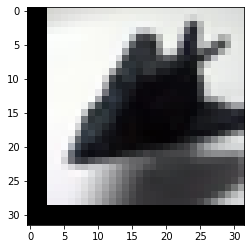

In [ ]:
show_example(*dataset[0])

## Dataset de Training y validación

Ya que el dataset no define un set de imaganes de validación, se separan 5 mil imágenes del set de entranmiento para realizar la validación. Se utiliza 'random split', con una semilla ('random_seed')

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)


Se crean los dataloadres para entrenamiento y validación, para cargar las imágenes en lotes o 'batchs'. Se define que cada batch tendrá 128 elementos.

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

Se crean los dataloadres para entrenamiento y para validación.
La opción shuffle hace que cada lote generado sea distinto, esta aleatoriedad ayuda a generalizar y aumentar la velocidad del proceso de entrenamiento.
Además, se setea el pin_memory= True, ya que se a mandar los datos de las CPU a la GPU y este parámetro permite alocar las muestras en una página bloqueada de moemoría, para realizar más rápida la transferencia.

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Utilizando make_grid de torchvision, podemos visualizar uno de los lotes.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        images_d= denormalize(images)
        ax.imshow(make_grid(images_d, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


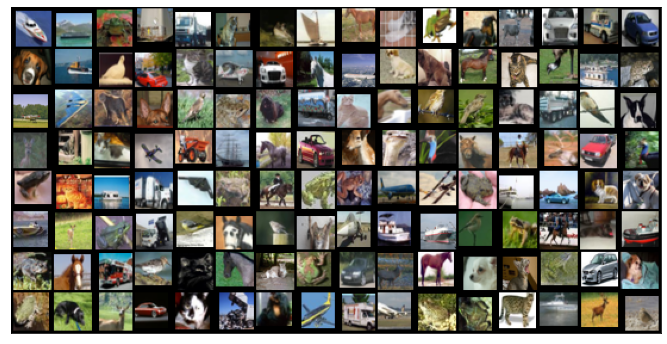

In [ ]:
show_batch(train_dl)

## Definición de Modelo (CNN)

Se utiliza nn.Conv2d de pytorch.

La convolución 2d, consiste en un kernel de un tamaño determinado que se va desplazando por la matriz de entrada, y cada elemento de multiplica y se suma, transformandose en un solo pixel de salida.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

La capa de convolución 2d, transforma la imágenes de 3 canales en un mapa de características de 16 canales, y la capa MaxPool2d reduce a la mitdad la altura y el ancho. El mapa de caparacterísticas se vuelve cada vez más pequeño, a medida que se incluyen más capas. Hasta terminar en un pequeño mapa de características que se puede aplanar en un fector. Luego se le agregan capas totalmente conectadas para obtener un vector de tamaño 10 por cada imágene.
The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">


In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Genera las predicciones
        loss = F.cross_entropy(out, labels) # Calcula las pérdidas
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    #Genera las predicciones
        loss = F.cross_entropy(out, labels)   # Calcula las pérdidas
        acc = accuracy(out, labels)           # Calcula la precisión
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina las pérdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine la precisión
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


Se utiliza `nn.Sequential` para encadenar las capas y las funcion es de activación en una única arquitectura de red.
Se utilzo el modelo VGG16.

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))                  ,
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.AvgPool2d(kernel_size=1, stride=1, padding=0)                          )                  
        self.classifier = nn.Linear(512, 10)              
    def forward(self, xb):
        out = self.network(xb)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out   
   

In [ ]:
import torchvision.models as models
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv

Se verifica que el modelo genere las salidas deseadas.
Cada una de las 10 salidas, es la probabilidad de que sea de cada clase. 
Es por ello que se selecciona la clase de mayor probabilidad para realizar la predicción.

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0802,  0.1320,  0.2323,  1.5586, -0.5331,  0.7159,  0.3335, -1.2983,
         0.2587,  0.7193], grad_fn=<SelectBackward0>)


Se definen las siguientes funciones para poder utilizar la GPU a través de CUDA.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Se envía el modelo al GPU.
Y también se cargan los data loaders, para que carguen automaticamente los lotes de información a la GPU.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Entrenamiento
Se definen 2 funciones, 'fit' para entrenar el modelo utilizando gradiente descendiente y 'evaluate' para evualuar su performance con el set de validación.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Se instancia el modelo nuevamente y se observan los reusltados de la validación con el conjunto inicial de paramemtros.

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.10296414792537689, 'val_loss': 2.302987575531006}

La precisión incial es de 10%, la cual es muy baja.
A partir de la seleccion de hiperparámetros, como la tasa de entrenamiento (lr), cantidad de epicas, tamaño de los lotes, se entrena al modelo.

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#Se entrena con lr= 0.001 y con optimización ADAM
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6799, val_loss: 1.4086, val_acc: 0.4714
Epoch [1], train_loss: 1.1552, val_loss: 1.0454, val_acc: 0.6264
Epoch [2], train_loss: 0.8877, val_loss: 1.1239, val_acc: 0.6298
Epoch [3], train_loss: 0.7414, val_loss: 0.7615, val_acc: 0.7398
Epoch [4], train_loss: 0.6457, val_loss: 0.8757, val_acc: 0.7205
Epoch [5], train_loss: 0.5835, val_loss: 0.7044, val_acc: 0.7692
Epoch [6], train_loss: 0.5206, val_loss: 0.6473, val_acc: 0.7946
Epoch [7], train_loss: 0.4773, val_loss: 0.7169, val_acc: 0.7803
Epoch [8], train_loss: 0.4461, val_loss: 0.5784, val_acc: 0.8094
Epoch [9], train_loss: 0.4088, val_loss: 0.5659, val_acc: 0.8148


Se grafica la precisión del conjunto de validación, para observar el comportamiento del modelo en el tiempo.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

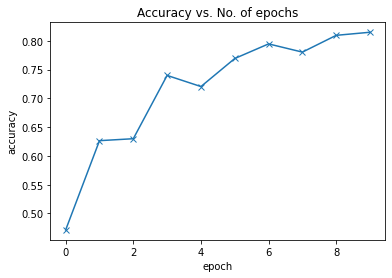

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

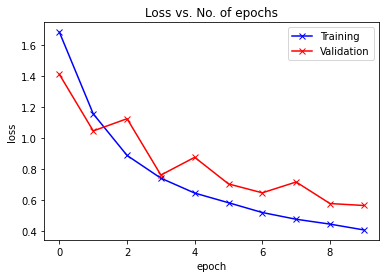

In [ ]:
plot_losses(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.4046, val_loss: 2.2729, val_acc: 0.1270
Epoch [1], train_loss: 1.9624, val_loss: 1.9118, val_acc: 0.2814
Epoch [2], train_loss: 1.5129, val_loss: 1.4307, val_acc: 0.4621
Epoch [3], train_loss: 1.1559, val_loss: 1.1401, val_acc: 0.5975
Epoch [4], train_loss: 0.9064, val_loss: 1.0765, val_acc: 0.6407
Epoch [5], train_loss: 0.7731, val_loss: 0.9557, val_acc: 0.6780
Epoch [6], train_loss: 0.6735, val_loss: 0.8860, val_acc: 0.7110
Epoch [7], train_loss: 0.5984, val_loss: 0.6320, val_acc: 0.7895
Epoch [8], train_loss: 0.5463, val_loss: 0.7449, val_acc: 0.7635
Epoch [9], train_loss: 0.5017, val_loss: 0.7021, val_acc: 0.7710


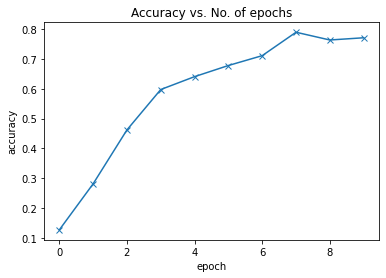

In [ ]:
model = to_device(Cifar10CnnModel(), device)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)

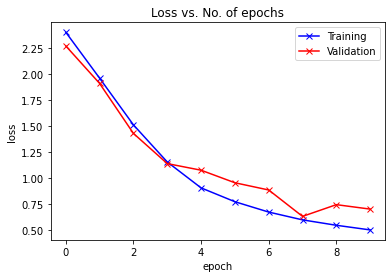

In [ ]:
plot_losses(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.5707, val_loss: 2.3174, val_acc: 0.0956
Epoch [1], train_loss: 2.3084, val_loss: 2.3109, val_acc: 0.0963
Epoch [2], train_loss: 2.3089, val_loss: 2.3062, val_acc: 0.0952
Epoch [3], train_loss: 2.3082, val_loss: 2.3178, val_acc: 0.0969
Epoch [4], train_loss: 2.3100, val_loss: 2.3099, val_acc: 0.0989
Epoch [5], train_loss: 2.3086, val_loss: 2.3113, val_acc: 0.1004
Epoch [6], train_loss: 2.3088, val_loss: 2.3107, val_acc: 0.0963
Epoch [7], train_loss: 2.3085, val_loss: 2.3165, val_acc: 0.0963
Epoch [8], train_loss: 2.3088, val_loss: 2.3178, val_acc: 0.0993
Epoch [9], train_loss: 2.3096, val_loss: 2.3130, val_acc: 0.0963


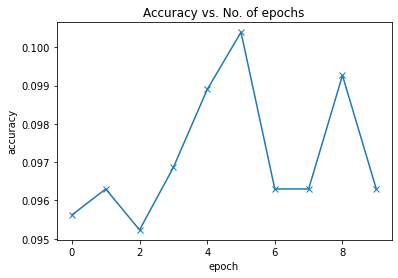

In [ ]:
model = to_device(Cifar10CnnModel(), device)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.1
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)

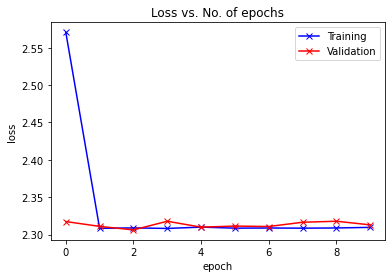

In [ ]:
plot_losses(history)

Se observa que la mayor precisión con 10 épocas se obtiene con lr= 0.001. 
Por lo tanto, se va entrenar nuevamente con este parámetro y 50 epocas para ver la evolución de la precisión como de las pérdidas.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6196, val_loss: 1.6062, val_acc: 0.4627
Epoch [1], train_loss: 1.0896, val_loss: 1.0943, val_acc: 0.6261
Epoch [2], train_loss: 0.8639, val_loss: 1.0480, val_acc: 0.6592
Epoch [3], train_loss: 0.7267, val_loss: 1.1181, val_acc: 0.6616
Epoch [4], train_loss: 0.6326, val_loss: 0.7136, val_acc: 0.7637
Epoch [5], train_loss: 0.5613, val_loss: 0.6037, val_acc: 0.7971
Epoch [6], train_loss: 0.5113, val_loss: 0.5894, val_acc: 0.8061
Epoch [7], train_loss: 0.4610, val_loss: 0.5826, val_acc: 0.8059
Epoch [8], train_loss: 0.4312, val_loss: 0.6062, val_acc: 0.8050
Epoch [9], train_loss: 0.4001, val_loss: 0.5020, val_acc: 0.8360
Epoch [10], train_loss: 0.3710, val_loss: 0.4590, val_acc: 0.8509
Epoch [11], train_loss: 0.3426, val_loss: 0.4909, val_acc: 0.8373
Epoch [12], train_loss: 0.3227, val_loss: 0.4553, val_acc: 0.8550
Epoch [13], train_loss: 0.3029, val_loss: 0.4487, val_acc: 0.8588
Epoch [14], train_loss: 0.2841, val_loss: 0.4401, val_acc: 0.8645
Epoch [15], train_lo

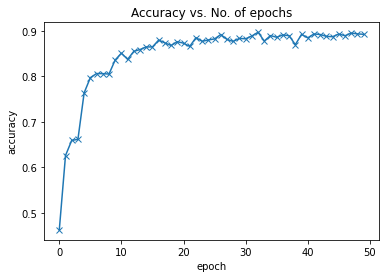

In [ ]:
model = to_device(Cifar10CnnModel(), device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)

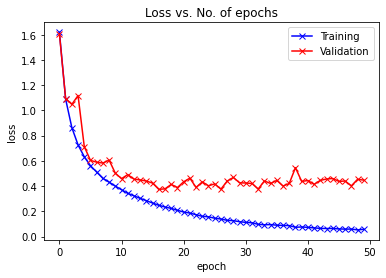

In [ ]:
plot_losses(history)

## Testing con imágenes
Se evalua el modelo con las imágenes del dataset Test, que consta de 10 mil imágenes. 
Se crea la carpeta de test.

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=transform_test)

Se define la función 'predict_image' que nos devuelve la clase de mayor probabilidad.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
    # return preds[0].item()


Label: airplane , Predicted: airplane


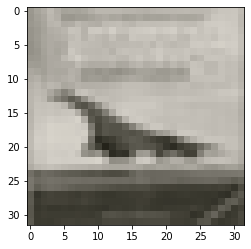

In [ ]:
img, label = test_dataset[0]
plt.imshow(denormalize(img[0]).permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ship , Predicted: ship


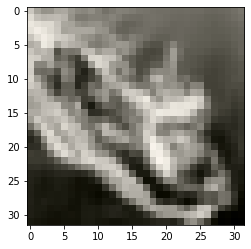

In [ ]:
img, label = test_dataset[8002]
plt.imshow(denormalize(img[0]).permute(1, 2, 0), cmap='hsv')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


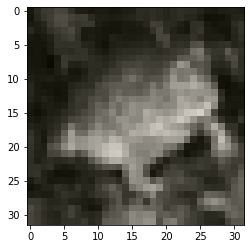

In [ ]:
img, label = test_dataset[6153]
plt.imshow(denormalize(img[0]).permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.901562511920929, 'val_loss': 0.39178964495658875}

##Guardar el modelo

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [ ]:
model2 = to_device(Cifar10CnnModel(), device)

Se carga el modelo guardado

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

Se verifica que se obtengan los mismos resultados que con el modelo original

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.901562511920929, 'val_loss': 0.39178964495658875}

## Pruebas con imágenes fuera del dataset CIFAR10

In [ ]:
from PIL import Image


def show_predict_image(img, z):
  w= img.size[0]
  h= img.size[1]
  if z>0:
    left = w/2-z
    top = h/2-z
    right = w/2+z
    bottom = h/2+z
    img=img.crop((left, top, right, bottom))
  plt.imshow(img)
  img= img.resize((32,32))
  img = transform_test(img)
  pred= predict_image(img, model2)
  return pred

In [ ]:
download_url ("https://upload.wikimedia.org/wikipedia/commons/e/ee/Fiat_600_Standard_1959.jpg" ,'./')

  0%|          | 0/116706 [00:00<?, ?it/s]

In [ ]:
img= Image.open('Fiat_600_Standard_1959.jpg')

'automobile'

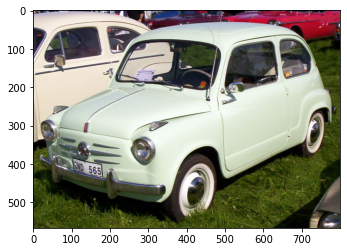

In [ ]:
show_predict_image(img, 0)

  0%|          | 0/490801 [00:00<?, ?it/s]

'truck'

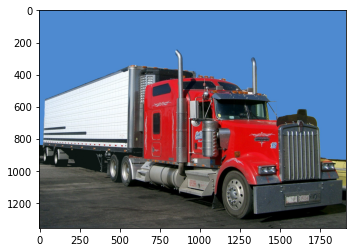

In [ ]:
download_url('https://upload.wikimedia.org/wikipedia/commons/2/2c/Kenworth_W900_semi_in_red.jpg','./')
img= Image.open('Kenworth_W900_semi_in_red.jpg')
show_predict_image(img, 0)

  0%|          | 0/676645 [00:00<?, ?it/s]

'truck'

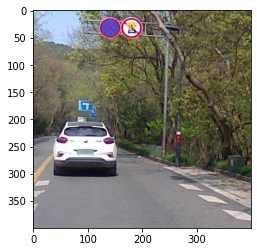

In [ ]:
download_url('https://once-for-auto-driving.github.io/assets/img/pic5.jpg','./')
img= Image.open('pic5.jpg')
show_predict_image(img, 200)

Se observa que el modelo no responde correctamente cuando el objeto a detectar tiene un fondo denso.

  0%|          | 0/2930915 [00:00<?, ?it/s]

'airplane'

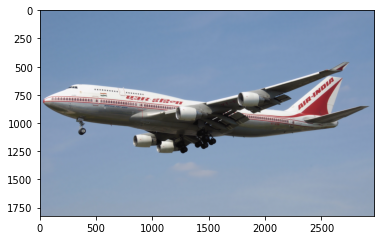

In [ ]:
download_url('https://upload.wikimedia.org/wikipedia/commons/e/e0/Air_india_b747-400_vt-esn_arp.jpg','./')
img= Image.open('Air_india_b747-400_vt-esn_arp.jpg')
show_predict_image(img, 0)

  0%|          | 0/1749548 [00:00<?, ?it/s]

'horse'

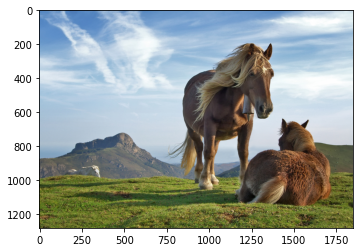

In [ ]:
download_url('https://upload.wikimedia.org/wikipedia/commons/a/a2/Biandintz_eta_zaldiak_-_modified2.jpg', './')
img= Image.open('Biandintz_eta_zaldiak_-_modified2.jpg')
show_predict_image(img, 0)

  0%|          | 0/5043704 [00:00<?, ?it/s]

'ship'

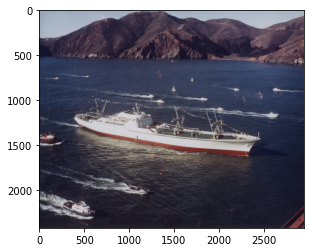

In [ ]:
download_url('https://upload.wikimedia.org/wikipedia/commons/d/dc/NSsavannah-1962.jpg','./')
img= Image.open('NSsavannah-1962.jpg')
show_predict_image(img, 0)

Se va a adquirir imágenes del dataset kitti, de la secuencia 7:
https://www.youtube.com/watch?v=iKB_mNFx8z0

'airplane'

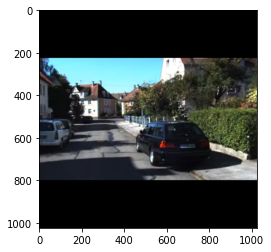

In [ ]:
img= Image.open('kitti_07_01.png')
show_predict_image(img, 512)

'automobile'

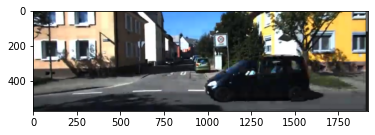

In [ ]:
img= Image.open('kitti_07_02.png')
show_predict_image(img, 0)

'truck'

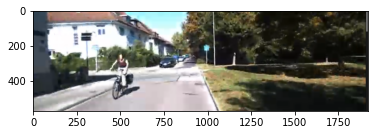

In [ ]:
img= Image.open('kitti_07_03.png')
show_predict_image(img, 0)